# LSTM, GRUs and CNNs

# Initialize

## Packages

### General

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from importlib import reload

Save data to Google Drive

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print("Running in Google Colab")
    in_colab=True
except:
    print("Running locally")
    in_colab=False

Mounted at /content/drive/
Running in Google Colab


Formatting

In [3]:
# For ASCII plots of training progress
try:
    import asciichartpy
except ImportError:
    !pip install asciichartpy
    import asciichartpy

from IPython.display import clear_output

### ML

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

Enables GPU support

In [5]:
if not torch.cuda.is_available():
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
    # Iterate through all available GPU devices and print their names.
    for idx in range(torch.cuda.device_count()):
        print(f"Device Name: {torch.cuda.get_device_name(idx)}")

Device Name: Tesla T4


In [6]:
import pandas as pd

## Helper functions

Here we define a couple of helper functions that we will reuse several times. Most of magic happens inside `my_functions.py`.

In [7]:
if in_colab:
  sys.path.append('/content/drive/MyDrive/Colab Notebooks/pytorch')

import my_functions as mine

## Data

### Get data

In [8]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-04-10 17:40:06--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-10 17:40:06--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.01s   

2025-04-10 17:40:06 (8.71 MB/s) - ‘ridership.tgz’ saved [108512/108512]

ridership/
ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv


In [9]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

### Prepares data

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model
will therefore be sequences (usually a single sequence per day once the model is in
production), each containing 56 values from time steps $t – 55$ to $t$. For each input
sequence, the model will output 14 values in a sequence to vector fashion: the forecasts for time step $t + 14$.

Before we continue looking at the data, let's **split the time series into three periods, for training, validation and testing**. We won't look at the test data for now:

In [10]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Defines the dataframe and features. Now `df_mulvar` is a DataFrame with five columns: the bus and rail data, plus three
columns containing the one-hot encoding of the next day’s type (recall that there are
three possible day types, W, A, and U).

In [14]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int)  # one-hot encode the day type

In [15]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


Next we can proceed much like we did earlier.
First we split the data into three periods, for training, validation, and testing:

In [16]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Training and validation data

In [11]:
ahead = 14       # forecast horizon
seq_length=56

In [12]:
class TSDataset(Dataset):
    def __init__(self, series, history, ahead=14, target_col=1):
        """
        Args:
            series (np.ndarray): the full time series data with shape (num_timesteps, num_features).
            history (int): the number of time steps to use as input (i.e. seq_length).
            ahead (int): the forecast horizon (number of steps ahead).
            target_col (int): the index of the target column (e.g. 1).

        The dataset windows are of length 'history + ahead'. For each window, the first
        'history' time steps become the input features and the following 'ahead' steps (from
        the target column) become the target.
        """
        self.series = series
        self.window_length = history + ahead
        self.history = history
        self.ahead = ahead
        self.target_col = target_col

    def __len__(self):
        # For a series with N timesteps, the number of windows is N - (window_length - 1)
        return len(self.series) - self.window_length + 1

    def __getitem__(self, idx):
        # Extract a window from the series
        window = self.series[idx: idx + self.window_length]
        # Convert to a torch tensor (float32)
        window = torch.tensor(window, dtype=torch.float32)

        # Split the window into:
        # - X: first 'history' steps with all features
        # - y: last 'ahead' steps for the target column
        X = window[:self.history, :]
        y = window[self.history:, self.target_col]
        return X, y

In [17]:
train_series = mulvar_train.to_numpy()
valid_series = mulvar_valid.to_numpy()

# Create dataset objects
train_dataset = TSDataset(train_series, history=seq_length, ahead=ahead, target_col=1)
valid_dataset = TSDataset(valid_series, history=seq_length, ahead=ahead, target_col=1)

# Create data loaders equivalent to the tf.keras dataset pipelines (with batch size of 32)
ahead_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
ahead_valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# LSTMs

Below: defines model, trains, saves (or loads) model to disk.

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_ahead):
        """
        Args:
            input_features (int): Number of features in the input time series (5 in your case).
            hidden_units (int): Number of units in the LSTM layer (32 in your case).
            num_ahead (int): The forecast horizon (14 in your case).
        """
        super().__init__()
        self.input_features = input_features
        self.hidden_units = hidden_units
        self.num_ahead = num_ahead

        self.lstm = nn.LSTM(input_size=self.input_features,
                            hidden_size=self.hidden_units,
                            batch_first=True)

        self.linear = nn.Linear(in_features=self.hidden_units,
                                out_features=self.num_ahead)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_length, input_features).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, num_ahead).
        """
        lstm_out, _ = self.lstm(x)
        last_time_step_output = lstm_out[:, -1, :]
        predictions = self.linear(last_time_step_output)

        return predictions

In [43]:
# initialize model
lstm_model = LSTMModel(input_features=5, hidden_units=32, num_ahead=ahead)

In [44]:
%time mine.train_save(lstm_model, ahead_train_loader, ahead_valid_loader, mine.fit_and_evaluate_mulvar, in_colab=in_colab, filename="lstm.pth", learning_rate=0.1, rewrite=True, epochs=1000)

Epoch 468/1000, Validation MAE: 0.036952
   -0.84  ┤
   -0.90  ┤
   -0.95  ┤
   -1.01  ┤
   -1.06  ┤
   -1.12  ┤
   -1.17  ┤
   -1.23  ┤
   -1.28  ┤
   -1.34  ┤
   -1.39  ┤╭───╮ ╭──╮  ╭─╮ ╭╮     ╭╮   ╭──╮╭╮  ╭╮╭──╮╭╮╭─╮   ╭╮       ╭╮╭─╮╭╮      ╭╮    ╭╮         ╭╮
   -1.45  ┼╯   ╰─╯  ╰──╯ ╰─╯╰─────╯╰───╯  ╰╯╰──╯╰╯  ╰╯╰╯ ╰───╯╰───────╯╰╯ ╰╯╰──────╯╰────╯╰─────────╯╰────────
Early stopping triggered at epoch 468
CPU times: user 1min 8s, sys: 3.1 s, total: 1min 11s
Wall time: 1min 13s


In [56]:
y_ahead=mine.forecast_ahead(seq_length, mulvar_valid[:seq_length], lstm_model)

# convert to pandas TS
y_aheadP = pd.Series(y_ahead[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

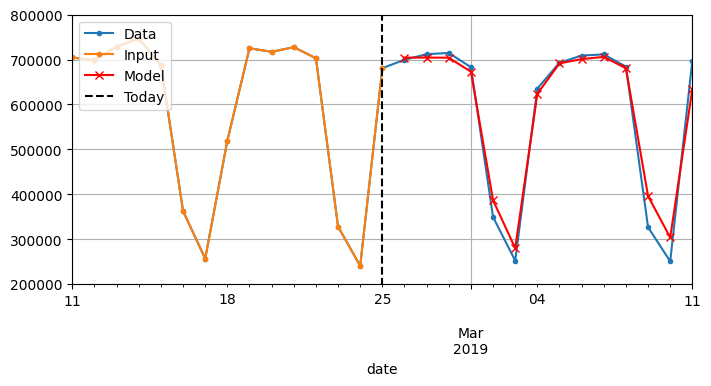

In [57]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_aheadP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_xlim(["2019-02-11", "2019-03-11"])
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.show()

# GRUs

In [47]:
class GRUModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_ahead):
        super().__init__()
        self.input_features = input_features
        self.hidden_units = hidden_units
        self.num_ahead = num_ahead

        self.gru = nn.GRU(input_size=self.input_features,
                            hidden_size=self.hidden_units,
                            batch_first=True)

        self.linear = nn.Linear(in_features=self.hidden_units,
                                out_features=self.num_ahead)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_time_step_output = gru_out[:, -1, :]
        predictions = self.linear(last_time_step_output)

        return predictions

In [48]:
# initialize model
gru_model = GRUModel(input_features=5, hidden_units=32, num_ahead=ahead)

In [49]:
%time mine.train_save(gru_model, ahead_train_loader, ahead_valid_loader, mine.fit_and_evaluate_mulvar, in_colab=in_colab, filename="gru.pth", learning_rate=0.1, rewrite=True, epochs=1000)

Epoch 409/1000, Validation MAE: 0.036892
   -0.74  ┤
   -0.80  ┤
   -0.87  ┤
   -0.93  ┤
   -1.00  ┤
   -1.06  ┤
   -1.12  ┤
   -1.19  ┤
   -1.25  ┤
   -1.32  ┤              ╭╮                                         ╭╮                                     ╭╮
   -1.38  ┼──────────────╯╰────────────────────────────────╮╭───────╯╰──────────╮╭─────────────────────────╯╰─
   -1.44  ┤                                                ╰╯                   ╰╯
Early stopping triggered at epoch 409
CPU times: user 4min 18s, sys: 751 ms, total: 4min 18s
Wall time: 4min 23s


In [50]:
y_ahead=mine.forecast_ahead(seq_length, mulvar_valid[:seq_length], gru_model)

# convert to pandas TS
y_aheadP = pd.Series(y_ahead[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

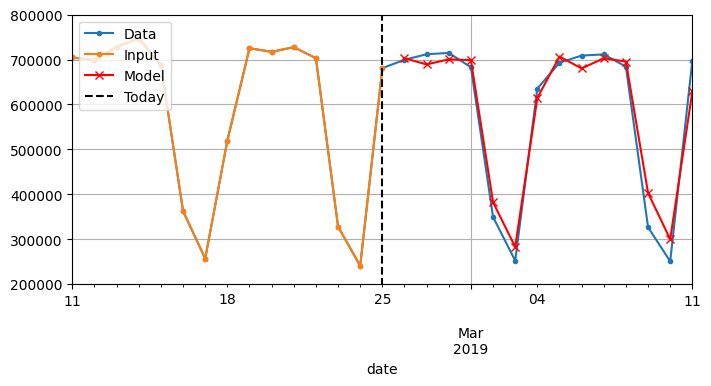

In [54]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_aheadP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_xlim(["2019-02-11", "2019-03-11"])
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.show()

# 1D CNNs

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0119 - mae: 0.1155


115491.04005098343

# WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 26ms/step - loss: 0.0796 - mae: 0.3159 - val_loss: 0.0239 - val_mae: 0.1723
Epoch 2/5
31/31 [==============================] - 1s 16ms/step - loss: 0.0172 - mae: 0.1585 - val_loss: 0.0182 - val_mae: 0.1545
Epoch 3/5
31/31 [==============================] - 1s 16ms/step - loss: 0.0159 - mae: 0.1561 - val_loss: 0.0181 - val_mae: 0.1505
Epoch 4/5
31/31 [==============================] - 1s 16ms/step - loss: 0.0155 - mae: 0.1535 - val_loss: 0.0175 - val_mae: 0.1479
Epoch 5/5
1/1 [==============================] - 0s 74ms/step - loss: 0.0166 - mae: 0.1407


140713.95993232727

# Extra Material – Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 26ms/step - loss: 0.0706 - mae: 0.2861 - val_loss: 0.0209 - val_mae: 0.1630
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0137 - mae: 0.1398 - val_loss: 0.0140 - val_mae: 0.1273
Epoch 3/5
31/31 [==============================] - 1s 20ms/step - loss: 0.0104 - mae: 0.1190 - val_loss: 0.0116 - val_mae: 0.1125
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 0.0086 - mae: 0.1048 - val_loss: 0.0096 - val_mae: 0.1020
Epoch 5/5
1/1 [==============================] - 0s 71ms/step - loss: 0.0087 - mae: 0.0953


95349.08086061478

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.